In [ ]:
!pip install -q blosc2==2.0.0
!pip install -q pycaret
!pip uninstall scikit-learn
!pip install scikit-learn==1.1.3

^C


In [1]:
import os
import warnings
from datetime import datetime

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and machine learning libraries
## Core libraries
from scipy import stats
from scipy.special import boxcox1p
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

## Preprocessing
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

## Machine learning models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
# from mlxtend.regressor import StackingCVRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

## Dimensionality reduction and clustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Suppress warnings
warnings.filterwarnings('ignore')



In [2]:
# List input files
pd.set_option('display.max_rows', 90)
print("Input files:\n")
for file in os.listdir("./house-price-data"):
    print(file)

Input files:

data_description.txt
sample_submission.csv
test.csv
train.csv


In [3]:
df_submission = pd.read_csv("./house-price-data/sample_submission.csv")

# train data
df_train = pd.read_csv('./house-price-data/train.csv')

# test data
df_test = pd.read_csv('./house-price-data/test.csv')

In [4]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
df_train.loc[:,df_train.isna().sum() >0]

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
1,80.0,NaN,NaN,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
3,60.0,NaN,NaN,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,NaN,NaN,0.0,Gd,TA,No,Unf,Unf,SBrkr,TA,Attchd,1999.0,RFn,TA,TA,NaN,NaN,NaN
1456,85.0,NaN,Stone,119.0,Gd,TA,No,ALQ,Rec,SBrkr,TA,Attchd,1978.0,Unf,TA,TA,NaN,MnPrv,NaN
1457,66.0,NaN,NaN,0.0,TA,Gd,No,GLQ,Unf,SBrkr,Gd,Attchd,1941.0,RFn,TA,TA,NaN,GdPrv,Shed
1458,68.0,NaN,NaN,0.0,TA,TA,Mn,GLQ,Rec,FuseA,NaN,Attchd,1950.0,Unf,TA,TA,NaN,NaN,NaN


In [6]:
num_train_rows, num_train_columns = df_train.shape
num_test_rows, num_test_columns = df_test.shape

print("Training Data:")
print(f"Number of Train Rows: {num_train_rows}")
print(f"Number of Train Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Test Rows: {num_test_rows}")
print(f"Number of Test Columns: {num_test_columns}\n")

Training Data:
Number of Train Rows: 1460
Number of Train Columns: 81

Test Data:
Number of Test Rows: 1459
Number of Test Columns: 80



In [7]:
# Check for duplicate values
duplicate_count = df_train.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    print("\nDuplicate rows:")
    print(df_train[df_train.duplicated(keep=False)])
else:
    print("No duplicate rows found in the dataset.")

Number of duplicate rows: 0
No duplicate rows found in the dataset.


In [8]:
train1 = df_train.drop(['Id', 'SalePrice'], axis = 1)

In [9]:
test1 = df_test.drop(['Id'], axis = 1)

In [10]:
#Combine test and train for the purpose of imputing missing values - renove target variable
target = df_train['SalePrice']
test_ids = df_test['Id']

data = pd.concat([train1, test1], axis = 0).reset_index(drop=True)

In [11]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [12]:
#Data Types
data.select_dtypes(np.number)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,6,2006
2915,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,286.0,0,24,0,0,0,0,0,4,2006
2916,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,576.0,474,0,0,0,0,0,0,9,2006
2917,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0.0,80,32,0,0,0,0,700,7,2006


In [13]:
data2 = data.copy()

In [14]:
data.select_dtypes('object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal
2915,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,CarPort,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
2916,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
2917,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,NaN,NaN,NaN,NaN,Y,NaN,MnPrv,Shed,WD,Normal


In [15]:
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

In [16]:
# Object columns with missing values
data2.select_dtypes('object').loc[:,data2.isna().sum() > 0].columns

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [17]:
#Fill Categorical Missing Values
# some columns the NA means something fill those with 'None'
# ['MSZoning','Utilities', 'Exterior1st', 'Exterior2nd','MasVnrType','Electrical', 'KitchenQual', 'Functional' ]


In [18]:
for col in ['MSZoning','Utilities', 'Exterior1st', 'Exterior2nd',
           'MasVnrType','Electrical', 'KitchenQual', 'Functional' ] :
     data2[col] = data2[col].fillna(data2[col].mode()[0])

In [19]:
for col in ['Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2' ,'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
        'PoolQC','Fence','MiscFeature','SaleType'] :
     data2[col] = data2[col].fillna('None')

In [20]:
data3 = data2.copy()

# Missing Numerical Values

In [21]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

In [22]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [23]:
import scipy.stats

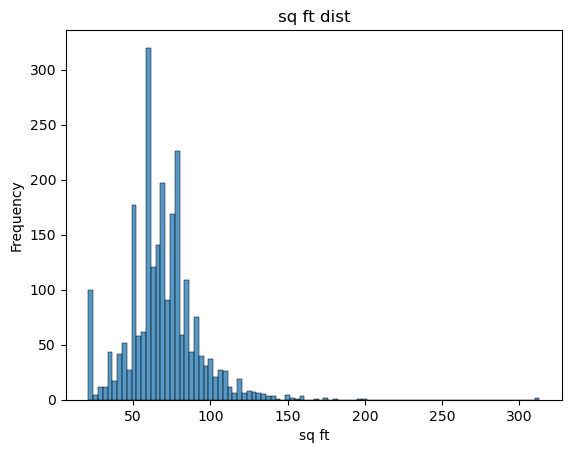

In [24]:
sns.histplot(data3['LotFrontage'])
plt.xlabel('sq ft')
plt.ylabel('Frequency')
plt.title('sq ft dist')
plt.show()

In [25]:
data3['LotFrontage'].mean() , data3['LotFrontage'].mode()

(69.30579531442663,
 0    60.0
 Name: LotFrontage, dtype: float64)

# For numerical columns impute na/s using KNN Regressor

In [26]:
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]:
    data3 = knn_impute(data3, column)

In [27]:
data4 = data3.copy()

# Feature Engineering ideas
- sqfeet without basement
- home age (sold - built)
- total bathrooms
- total rooms?

In [28]:
data4.columns[data4.columns.str.contains("Bath")]

Index(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], dtype='object')

In [29]:
data4.columns[data4.columns.str.contains("SF")]

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF'],
      dtype='object')

# Feature transformations

In [30]:
scipy.stats.skew(data4.select_dtypes(np.number))

array([ 1.34075114, 12.8224314 ,  0.19711045,  0.57031205, -0.59980555,
       -0.45102038,  2.60368152,  1.42551624,  4.14611071,  0.91932181,
        1.16280584,  1.46960442,  0.86167475, 12.088761  ,  1.26935769,
        0.62437257,  3.93159384,  0.16760573,  0.69456649,  0.32632435,
        4.30225437,  0.75836691,  0.7334946 , -0.34632694, -0.21859252,
        0.24089573,  1.84243281,  2.53511373,  4.00389122, 11.37606468,
        3.9466937 , 16.89832792, 21.94719481,  0.19588394,  0.13239881])

In [31]:
skew_df = pd.DataFrame(data4.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data4[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df.head()

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True


In [32]:
skewed = skew_df[skew_df['Skewed'] == True]

### Log transformations for skewed cols account for zero values Log undefined

In [33]:
np.log(0), np.log1p(0)

(-inf, 0.0)

In [34]:
for col in skewed['Feature'].values:
    data4[col] = np.log1p(data4[col])

### Month column is numeric but is really cyclical

In [35]:
data4['MoSold'].unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6], dtype=int64)

### Cosine transformation on the Month colum(seee desmos.com) 1 and 12 months will be similar and 6 will be the oppsite end of the wave

In [36]:
data4['MoSold'] = (-np.cos(0.5236 * data4['MoSold']))

In [37]:
data4['MoSold'].head()

0   -0.499998
1    0.866028
2   -0.000011
3   -0.499998
4   -1.000000
Name: MoSold, dtype: float64

In [38]:
data5 = data4.copy()

# Encode Categorical Columms

In [39]:
data5 = pd.get_dummies(data5)

# Scaling

In [40]:
data6 = data5.copy()

In [41]:
scaler = StandardScaler()

In [42]:
scaler.fit(data6)
data6 = pd.DataFrame(scaler.transform(data6), index=data6.index, columns= data6.columns)

In [43]:
data6.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.064176,-0.103719,0.646183,-0.435439,1.040634,0.896833,1.210174,0.783229,-0.363076,-0.326949,...,-0.298629,-0.018512,-0.049029,0.395018,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.536077,0.146544,-0.063185,1.906370,0.161526,-0.395604,-0.804554,0.892444,-0.363076,0.013428,...,-0.298629,-0.018512,-0.049029,0.395018,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.066112,0.457629,0.646183,-0.435439,0.975922,0.848965,1.137926,0.658154,-0.363076,0.240016,...,-0.298629,-0.018512,-0.049029,0.395018,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.295084,0.136301,0.646183,-0.435439,-1.869638,-0.682812,-0.804554,0.386923,-0.363076,0.356870,...,-0.298629,-0.018512,-0.049029,0.395018,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.677357,0.922662,1.355551,-0.435439,0.943542,0.753229,1.430432,0.758108,-0.363076,0.304906,...,-0.298629,-0.018512,-0.049029,0.395018,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


# Target Transformation
- some skew in the target values log makes it more normal
- if we take the log of the target will need ot exponentiate it back

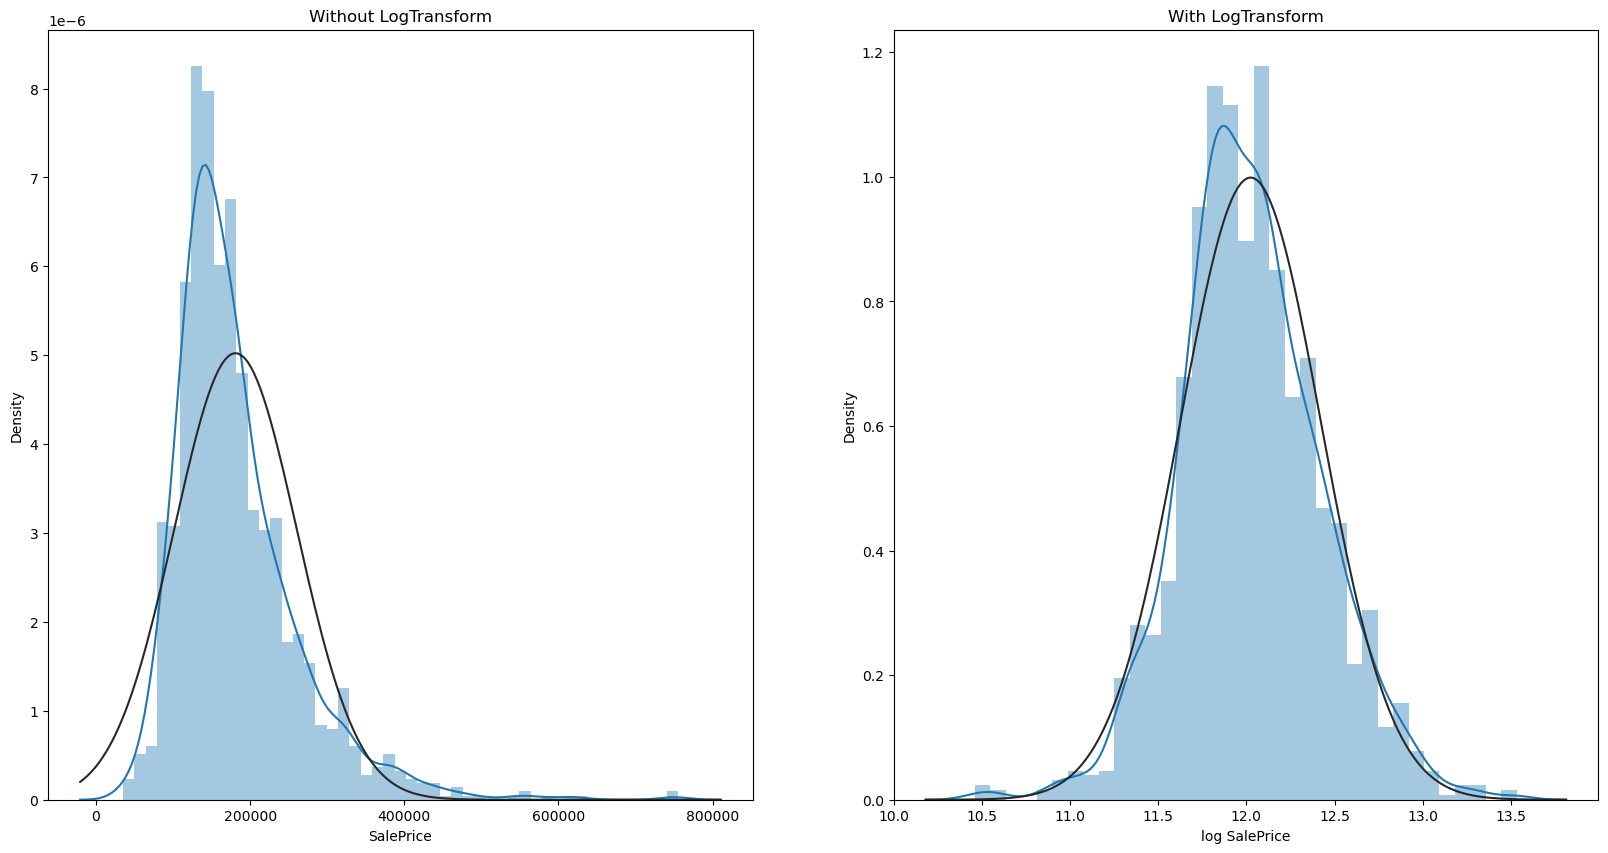

In [44]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.distplot(target, fit = scipy.stats.norm ) # compare to normal
plt.title('Without LogTransform')
plt.xlabel("SalePrice")
plt.subplot(1,2,2)
sns.distplot(np.log(target), fit = scipy.stats.norm ) # compare to normal
plt.xlabel("log SalePrice")
plt.title('With LogTransform')
plt.show()

In [45]:
log_target = np.log(target)

# PyCaret https://pycaret.org/

In [46]:
from pycaret.regression import setup, compare_models

# Model Selection

In [47]:
data7 = data6.copy()

In [48]:
# split the data back into train and test
train_final = data7.loc[:df_train.index.max(),:].reset_index(drop=True).copy()
test_final = data7.loc[df_train.index.max()+1:,:].reset_index(drop=True).copy()

In [49]:
test_final.index, train_final.index

(RangeIndex(start=0, stop=1459, step=1),
 RangeIndex(start=0, stop=1460, step=1))

In [53]:
_ = setup(data=pd.concat([train_final, log_target], axis=1), target="SalePrice")

,Description,Value
0,Session id,3670
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 318)"
4,Transformed data shape,"(1460, 318)"
5,Transformed train set shape,"(1021, 318)"
6,Transformed test set shape,"(439, 318)"
7,Numeric features,317
8,Preprocess,True
9,Imputation type,simple


In [56]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0910,0.0180,0.1326,0.8865,0.0103,0.0076,0.1380
lightgbm,Light Gradient Boosting Machine,0.0962,0.0199,0.1397,0.8734,0.0108,0.0080,0.2120
br,Bayesian Ridge,0.0885,0.0200,0.1382,0.8732,0.0106,0.0074,0.0340
omp,Orthogonal Matching Pursuit,0.0896,0.0209,0.1401,0.8680,0.0108,0.0075,0.0270
rf,Random Forest Regressor,0.0989,0.0220,0.1465,0.8610,0.0113,0.0083,0.2980
et,Extra Trees Regressor,0.1017,0.0231,0.1508,0.8532,0.0116,0.0085,0.3200
ridge,Ridge Regression,0.0947,0.0233,0.1491,0.8526,0.0115,0.0079,0.0250
ada,AdaBoost Regressor,0.1269,0.0304,0.1733,0.8062,0.0134,0.0106,0.0930
knn,K Neighbors Regressor,0.1425,0.0407,0.2008,0.7392,0.0155,0.0119,0.0370
dt,Decision Tree Regressor,0.1492,0.0457,0.2120,0.7071,0.0165,0.0125,0.0400


GradientBoostingRegressor(random_state=3670)

Gradient Boosting performed the best on the MSE and RMSE. will use that as baseline

In [59]:
baseline_model = GradientBoostingRegressor()

In [60]:
baseline_model.fit(train_final, log_target)

GradientBoostingRegressor()

In [63]:
kf = KFold(n_splits = 10)

In [64]:
results = cross_val_score(baseline_model, train_final, log_target, scoring= 'neg_mean_squared_error', cv=kf )

In [68]:
results

array([-0.01665153, -0.01030719, -0.01343361, -0.02692334, -0.0238839 ,
       -0.01224512, -0.01708424, -0.01173654, -0.01315831, -0.0199396 ])

In [76]:
np.mean(-results)

0.01653633653106898

In [78]:
# to bring results into a meaningful scale
np.exp(np.sqrt(np.mean(-results)))

1.1372279606378

In [79]:
# make Prediction on submissing

In [83]:
predictions = np.exp(baseline_model.predict(test_final))

In [84]:
predictions

array([123288.64772146, 155008.51076606, 181227.73526697, ...,
       150152.0612485 , 117342.06261141, 236488.09634167])

In [90]:
#concat testids and predicitons 
finaL_preds = pd.concat([test_ids, pd.Series(predictions, name='SalePrice')], axis=1)

In [91]:
finaL_preds

,Id,SalePrice
0,1461,123288.647721
1,1462,155008.510766
2,1463,181227.735267
3,1464,187221.845369
4,1465,197528.651634
...,...,...
1454,2915,77909.412247
1455,2916,85651.071776
1456,2917,150152.061248
1457,2918,117342.062611


In [93]:
finaL_preds.to_csv('./gbr_submission.csv', index=False, header=True)

In [96]:
df_test.iloc[0]

Id                 1461
MSSubClass           20
MSZoning             RH
LotFrontage        80.0
LotArea           11622
                  ...  
MiscVal               0
MoSold                6
YrSold             2010
SaleType             WD
SaleCondition    Normal
Name: 0, Length: 80, dtype: object